In [48]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py

[[[[-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]]

  [[-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.   0.3  0.3 ...  0.3  0.3 -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]]

  [[-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.   0.3  0.3 ...  0.3  0.3 -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]]

  ...

  [[-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.   0.7  0.7 ...  0.7  0.7 -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]]

  [[-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.   0.7  0.7 ...  0.7  0.7 -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]]

  [[-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]]]


 [[[-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]]

  [[-1.  -1.  -1.  ... -1.  -1.  -1. ]
   [-1.   0.7  0.7 ...  0.7  0.7 -1. ]
   [-1.  -1.  -1.  ... -1.  -1.  -1. ]]

  [[-1.  -1.  -1.  ... -1.  -1.  -1. ]


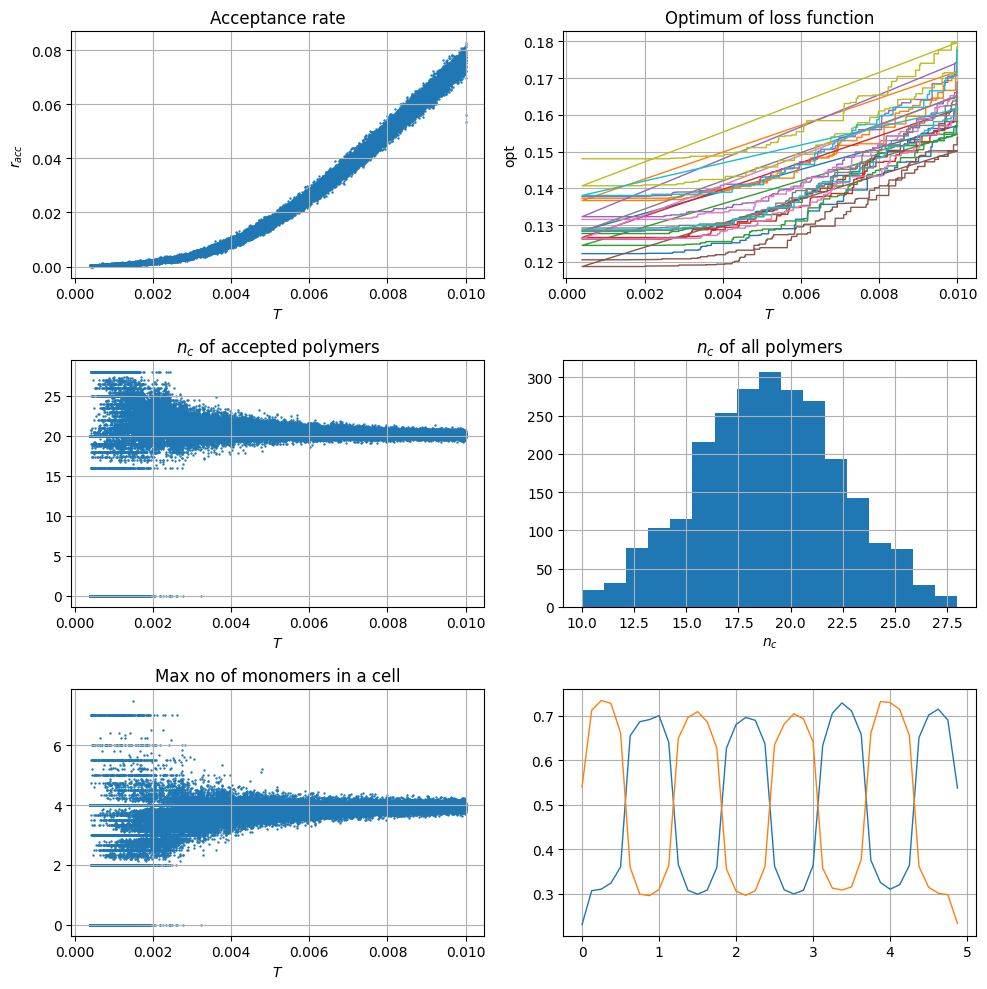

In [58]:
Nbars=[100]
offset=1 #to account for area51
fig, axs = plt.subplots(3, 2, figsize=(10, 10),dpi=100)
axs=axs.flatten()
for i in range(len(axs)):
    axs[i].grid()

axs[0].set_title("Acceptance rate")
axs[1].set_title("Optimum of loss function")
axs[2].set_title("$n_c$ of accepted polymers")
axs[3].set_title("$n_c$ of all polymers")
axs[4].set_title("Max no of monomers in a cell")

axs[0].set_xlabel('$T$')
axs[1].set_xlabel('$T$')
axs[2].set_xlabel('$T$')
axs[4].set_xlabel('$T$')
axs[0].set_ylabel('$r_{acc}$')
axs[1].set_ylabel('opt')
#plt.yscale('log')
for Nbar in Nbars:
    with h5py.File(f'Nbar{Nbar}/coord.h5', 'r') as f:
        ##number of beads per polymer
        N=int(f['parameter/reference_Nbeads'][()]) 
        #kappa
        kappa=30/N
        ##number of polymers
        n_polym=int(f['parameter/n_polymers'][()]) 
        n_poly_type=int(f['parameter/n_poly_type'][()]) 
        n_types=int(f['parameter/n_types'][()]) 
        ##box dimensions 
        lxyz=np.array(f['parameter/lxyz'])
        ##box discretization
        nxyz=np.array(f['parameter/nxyz'])
        #discretization
        dxyz=lxyz/nxyz
        #adjust lengths and discretizations
        lxyz=lxyz-2*offset*dxyz
        nxyz=nxyz-2*offset
        #umbrella field
        umb_field=np.array(f["umbrella_field"])
        #area51
        area51=np.array(f["area51"])
    with h5py.File(f'Nbar{Nbar}/coord_ana.h5', 'r') as f:
        phi=np.array(f['density_field'])[1::2]
    phi=phi[:,:,area51==0].reshape(phi.shape[0],phi.shape[1],nxyz[0],nxyz[2])
    phi=phi.mean(axis=(0,3))*scale
    print(umb_field)
    #cell volume
    V_cell=np.prod(dxyz)
    #number of accessible cells 
    n_cells=int(len(area51[area51==0]))
    #field scaling type
    scale=n_cells/(N*n_polym)
    #volume
    V=V_cell*n_cells
    #average bead density
    rho0=N*Nbar
    #beads per cell
    rhoc=rho0*V_cell 
    #natural density fluctuations
    var_phi=1/(rho0*kappa*V_cell) 
    T=np.loadtxt(f"Nbar{Nbar}/T.csv")
    n_T=len(T)#number of temperatures
    acc_rate=np.loadtxt(f"Nbar{Nbar}/acc_rate.csv")
    acc_rate=acc_rate.reshape(int(acc_rate.shape[0]/n_T),n_T).mean(axis=0)
    opt=np.loadtxt(f"Nbar{Nbar}/opt.csv")/(2*n_cells)
    opt=opt.reshape(int(opt.shape[0]/n_T),n_T)
    num_cells=np.loadtxt(f"Nbar{Nbar}/num_cells.csv") 
    num_cells=num_cells.reshape(int(num_cells.shape[0]/n_T),n_T).mean(axis=0)
    max_monos_cell=np.loadtxt(f"Nbar{Nbar}/max_monos_cell.csv") 
    max_monos_cell=max_monos_cell.reshape(int(max_monos_cell.shape[0]/n_T),n_T).mean(axis=0)
    axs[0].scatter(T,acc_rate,s=0.5,label=r"$\rho_{cell}=$"+f"{rhoc}")
    for i in range(len(opt)):
        axs[1].plot(T,opt[i]/var_phi,lw=1)
    axs[2].scatter(T,num_cells,s=0.5)
    axs[4].scatter(T,max_monos_cell,s=0.5)

    l_plot=np.arange(0,lxyz[0],dxyz[0])
    axs[5].plot(l_plot,phi[0],lw=1)
    axs[5].plot(l_plot,phi[1],lw=1)
#acc_rate=np.loadtxt(f"large_cells/acc_rate.csv")
#acc_rate=acc_rate.reshape(int(acc_rate.shape[0]/n_T),n_T).mean(axis=0)
#plt.plot(T,acc_rate,lw=1)
num_cells_all=np.loadtxt(f"num_cells_Nbar{Nbar}/num_cells.csv")
axs[3].set_xlabel("$n_c$")
axs[3].hist(num_cells_all,bins=17)
plt.tight_layout()
plt.savefig("accrate_1.pdf")
